# Visualizing spherical data using cartopy

## Synopsis

- Use projections to create 2d plots of spherical data

## Get going with cartopy

In [1]:
import netCDF4
import numpy
import matplotlib.pyplot as plt

# This notebook uses "cartopy" for which the core package is the "Coordinate Reference System" or "crs"
# Obtain cartopy with `conda install -c conda-forge cartopy`

import cartopy.crs

# Many cartopy examples use this alias
#import cartopy.crs as ccrs

Here we we illustrate how easy it is to use the cartopy package to solve the problem of visualizating spherical data. The documentation for cartopy is at https://scitools.org.uk/cartopy/docs/latest/ .

Let's look at the same model output as the previous noteboook, that resides on the native curvilinear grid of the model.

In [2]:
nc = netCDF4.Dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/1pctCO2/r1i1p1f1/Omon/tos/gn/v20181212/tos_Omon_MIROC6_1pctCO2_r1i1p1f1_gn_330001-334912.nc')

We'll pre-load the data for efficiency. Again, this is only to avoid repeated transfers and usually we would use deferred reading.

In [3]:
# For efficiency, load relevant data into memory 
tos = nc.variables['tos'][0] # SST at a particular time
vlon = nc.variables['vertices_longitude'][:] # Vertex longitudes in inefficient (:,:,:) form
vlat = nc.variables['vertices_latitude'][:] # Vertex latitudes in inefficient (:,:,:) form

The following two notebook cells extract the contiguous vertex coordinates and store the mesh data in arrays `flon`, `flat`.

## Extract geographic mesh coordinates

This is the exact same code we used to previously to re-arrange the vertex data into a more usable shape.

In [4]:
# First create the latitude array for the mesh (which needs no value adjustments)
flat = numpy.zeros( (nc.variables['y'].shape[0]+1, nc.variables['x'].shape[0]+1) ) # 1 larger than cell shape
flat[1:,1:] = vlat[:,:,2] # Copy NE corner values to mesh
flat[0,1:] = vlat[0,:,1] # Copy SE corner for bottom row only
flat[1:,0] = vlat[:,0,3] # Copy NW corner for left column only
flat[0,0] = vlat[0,0,0] # Copy SW corner for SW cell only

In [5]:
# Now create the longitude array for the mesh
flon = numpy.zeros( (nc.variables['y'].shape[0]+1, nc.variables['x'].shape[0]+1) )
flon[1:,1:] = vlon[:,:,2] # Copy NE corner values to mesh
flon[0,1:] = vlon[0,:,1] # Copy SE corner for bottom row only
flon[1:,0] = vlon[:,0,3] # Copy NW corner for left column only
flon[0,0] = vlon[0,0,0] # Copy SW corner for SW cell only

## The Plate-Carree projection

To use cartopy, you declare the projection you wish to use in the visualization in the axes (i.e. here I use `plt.axes()` below). When you call pcolormesh for those axes (i.e. with `ax.pcolormesh()`) you specify the nature of the coordinates of the data with `transform=`. Most ESM output provides the coordinates as geographic latitude and longitude, or spherical coordinates. Coordinates are distinct from the nature of the grid or mesh. The mesh could be a convoluted 

The "Platte Carree" projection is a simply a "latitude-longitude" plot: x and y in the plot correspond linearly to longitude and latitude. So we would normally use `transform=cartopy.crs.PlateCarree()`. When you ask for a "lat-lon" plot

Now to make a rudimentary "lat-lon" plot we use `projection=cartopy.crs.PlateCarree()` as follows:

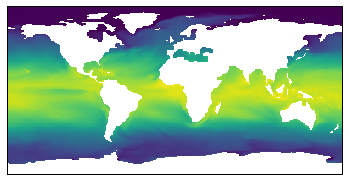

In [6]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.PlateCarree());

# Plot the data
ax.pcolormesh( flon, flat, tos );

which looks artifact free! And to add more information to the plot ...

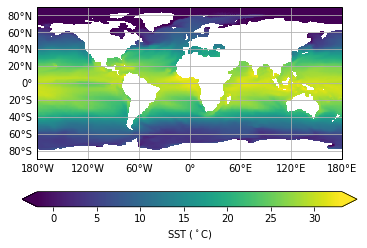

In [7]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.PlateCarree());

pcm = ax.pcolormesh( flon, flat, tos );

# Add a color scale
plt.colorbar(pcm, ax=ax, orientation='horizontal', extend='both', label='SST ($^\circ$C)')

# Draw coordinate grid
gl = ax.gridlines(draw_labels=True);
# Control labelling
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

## Other projections

The great thing about _cartopy_ is it let's us use other projections very easily...

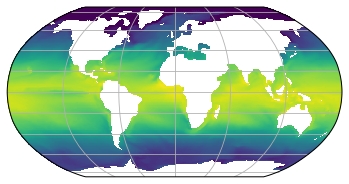

In [8]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.Robinson());

# Plot the data
ax.pcolormesh( flon, flat, tos, transform=cartopy.crs.PlateCarree() );

# Draw coordinate grid
gl = ax.gridlines();

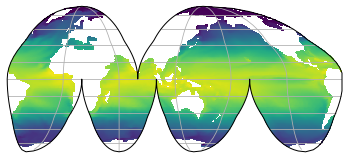

In [9]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.InterruptedGoodeHomolosine(central_longitude=120));

# Plot the data
ax.pcolormesh( flon, flat, tos, transform=cartopy.crs.PlateCarree() );

# Draw coordinate grid
gl = ax.gridlines();

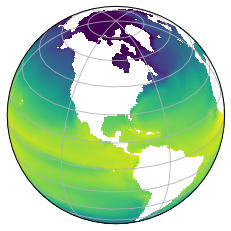

In [10]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.Orthographic(central_longitude=-90, central_latitude=30));

# Plot the data
ax.pcolormesh( flon, flat, tos, transform=cartopy.crs.PlateCarree() );

# Draw coordinate grid
gl = ax.gridlines();

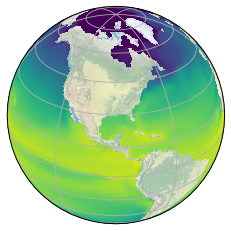

In [11]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.NearsidePerspective(central_longitude=-90, central_latitude=30));

# Plot the data
ax.pcolormesh( flon, flat, tos, transform=cartopy.crs.PlateCarree() );

# Stock image of planet will be seen through "missing data" holes (white)
ax.stock_img()

# Draw coordinate grid
gl = ax.gridlines();

(-1642900.829389604, 5476336.097965347)

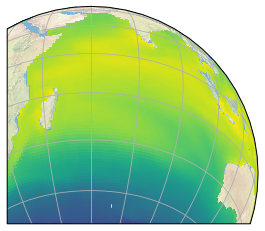

In [12]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.NearsidePerspective(central_longitude=60, central_latitude=-40));

# Plot the data
ax.pcolormesh( flon, flat, tos, transform=cartopy.crs.PlateCarree() );

# Stock image of planet will be seen through "missing data" holes (white)
ax.stock_img()

# Draw coordinate grid
gl = ax.gridlines();

#ax.set_extent([-80,80,-20,80], crs=cartopy.crs.PlateCarree() )

RR = ax.get_xlim()[1]
ax.set_xlim((-0.5*RR,RR))
ax.set_ylim((-0.3*RR,RR))

## Avoiding re-organization of the mesh data

Big reveal! I started above by re-sampling the vertex mesh data into a usable shape. That is the right way to plot things. However, for most purposes the following shortcut works, _but only with cartopy_.

Even though previously we saw that using the cell-center coordinates did _not_ work using pcolormesh, with cartopy projections the wrap around is handled properly so you can use pcolormesh with cell-center coordinates. Just remember it is skipping a row and column of data! You normally will not notice the difference. However, strictly speaking this approach is not showing you everything - for instance, if the extrema in the data were in the missing row/column then the automatic color scales would be affected.

In [13]:
lon = nc.variables['longitude'][:] # Cell-center longitude coordinate of data
lat = nc.variables['latitude'][:] # Cell-center latitude coordinate of data

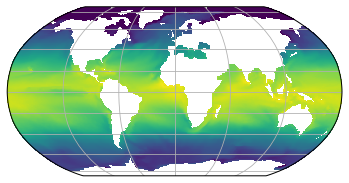

In [14]:
# Create axes and register a "projection" for subsequent plot commands to use
ax = plt.axes(projection=cartopy.crs.Robinson());

# Plot the data
ax.pcolormesh( lon, lat, tos, transform=cartopy.crs.PlateCarree() );

# Draw coordinate grid
gl = ax.gridlines();

## Summary

- cartopy allows us to look at data in spherical coordinates.
- Mesh coordinates are still needed but short-cutting with data-coordinates is often good enough.
- Numerous projections available.